<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [163]:
# !pip install catboost
# !pip install shap
# !pip install boruta

In [164]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import warnings
import shap

from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.model_selection import cross_val_score, train_test_split
from catboost import CatBoostRegressor

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
color = sns.color_palette()
from tqdm import tnrange,tqdm
import matplotlib.ticker as ticker
from IPython.core.pylabtools import figsize

%matplotlib inline

import warnings
warnings.simplefilter("ignore", FutureWarning)

warnings.simplefilter("ignore", UserWarning)

In [165]:
# from google.colab import drive
# drive.mount('/content/drive/')

In [166]:
# name = 'PSIBUE11'
# data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/final/'+name+'.csv')
GTP = 'PSIBUE11'
data = pd.read_csv('/home/playground/Potreb/Data/'+GTP+'.csv')
data = data[data['datehour']>='2015-01-01']
data.tail(5)


,datehour,Load,Type,DoY,DoW,Hour,Hour/2,Day,DiM,Temp,H,fi,V,plan
211688,2022-01-29 06:00:00,2.353,Выходной,29,5,6,13.0,29,0.935484,-21.9475,777.09375,97.125,1.52625,к
211689,2022-01-29 06:30:00,2.524,Выходной,29,5,6,14.0,29,0.935484,-21.9475,777.09375,97.125,1.52625,к
211690,2022-01-29 07:00:00,3.150,Выходной,29,5,7,15.0,29,0.935484,-21.9475,777.09375,97.125,1.52625,к
211691,2022-01-29 07:30:00,2.713,Выходной,29,5,7,16.0,29,0.935484,-21.9475,777.09375,97.125,1.52625,к
211692,2022-01-29 08:00:00,1.294,Выходной,29,5,8,17.0,29,0.935484,-21.9475,777.09375,97.125,1.52625,к


In [167]:
data.describe()

,Load,DoY,DoW,Hour,Hour/2,Day,DiM,Temp,H,fi,V
count,124097.000000,124097.000000,124097.000000,124097.000000,124097.000000,124097.000000,124097.000000,124097.000000,124097.000000,124097.000000,124097.000000
mean,2.302757,181.295575,3.000661,11.498940,24.497877,15.719421,0.515956,1.686478,737.046971,73.950110,3.048344
std,2.371393,106.330600,1.999331,6.922392,13.853812,8.794858,0.288299,13.620135,12.610682,11.317723,1.246250
min,0.431000,1.000000,0.000000,0.000000,1.000000,1.000000,0.032258,-44.250000,715.250000,30.000000,0.021739
25%,0.988000,89.000000,1.000000,5.000000,12.000000,8.000000,0.266667,-8.484375,728.625000,67.145833,2.119870
50%,1.351000,181.000000,3.000000,11.000000,24.000000,16.000000,0.516129,2.375000,733.593750,75.177083,2.921875
75%,2.108000,273.000000,5.000000,17.000000,36.000000,23.000000,0.766667,13.812500,740.713542,82.390625,3.828125
max,11.982000,366.000000,6.000000,23.000000,48.000000,31.000000,1.000000,28.250000,782.525000,99.000000,9.250000


Text(0.5, 1.0, 'График потребления')

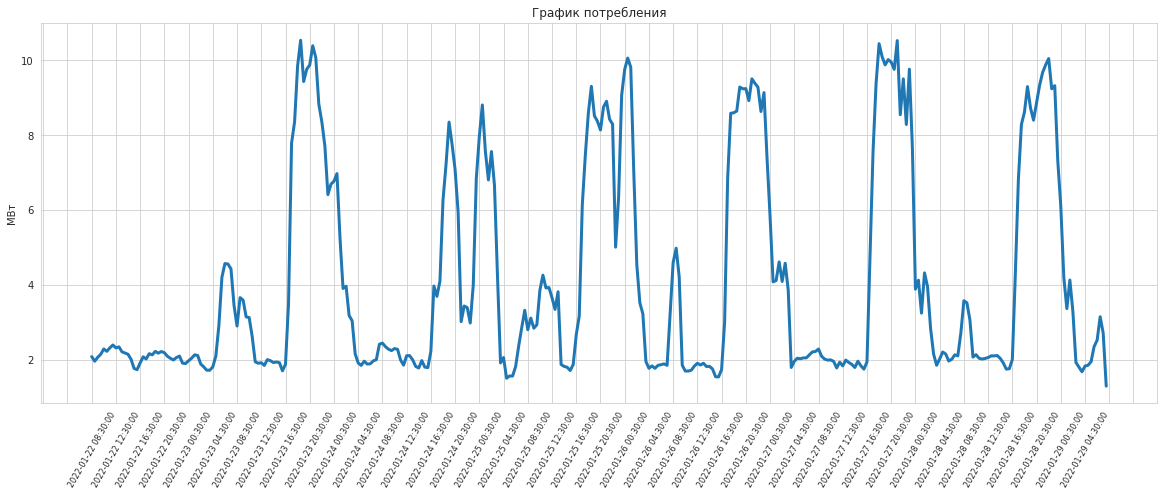

In [168]:

figsize(20, 7)
fontsize = 10
sns.set_style('whitegrid')
fig,ax = plt.subplots()

sns.lineplot(x=data.datehour[-48*7:] ,y=data.Load[-48*7:], linewidth = 3)

ax.xaxis.set_major_locator(ticker.MultipleLocator(8))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
plt.xlabel(''); 
plt.ylabel('МВт'); 
plt.xticks(rotation=60,fontsize=8)
plt.title('График потребления')

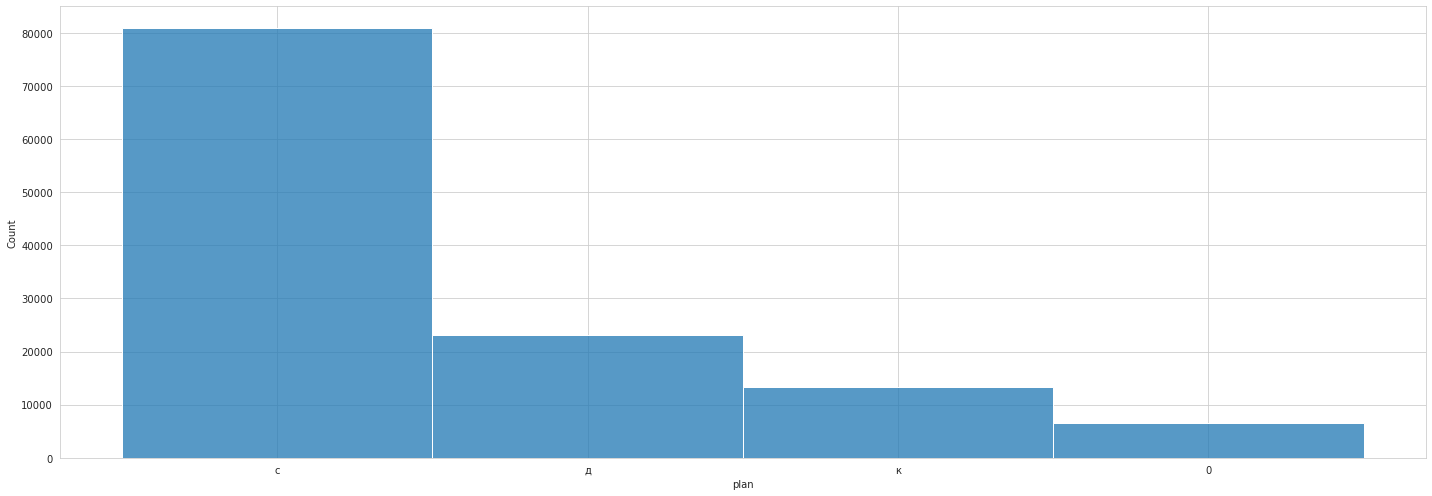

In [169]:
figsize=(15,6)

sns.histplot(data['plan'])


plt.tight_layout()
plt.show()

In [170]:
data['plan'] = data['plan'].str.lower()

In [171]:
data=data.query("plan != '0'")

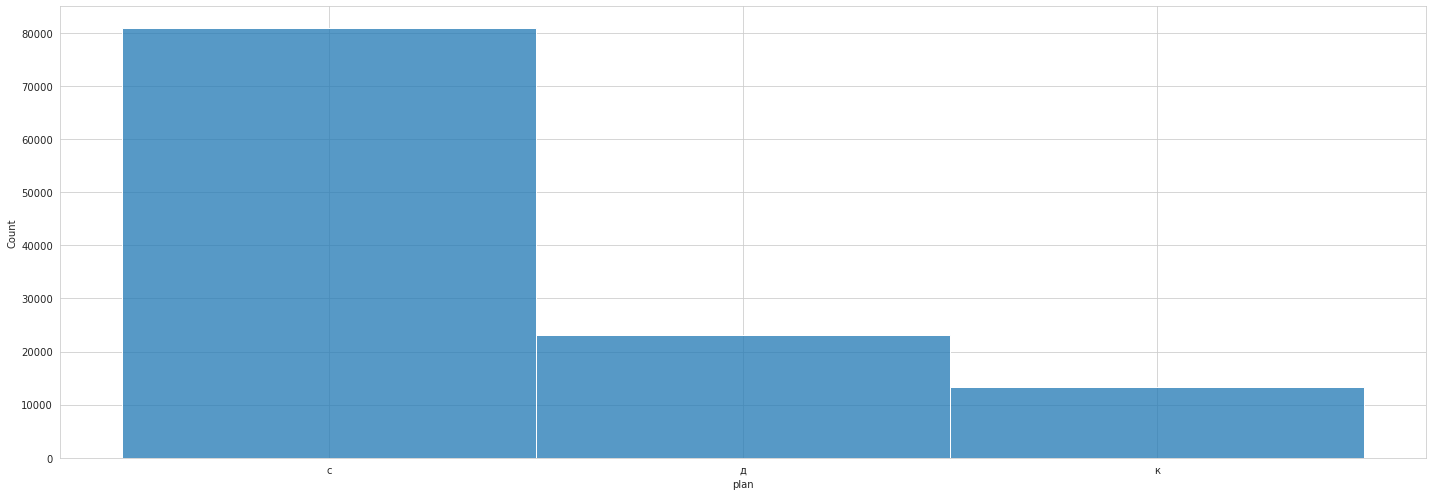

In [172]:
figsize=(15,6)

sns.histplot(data['plan'])


plt.tight_layout()
plt.show()

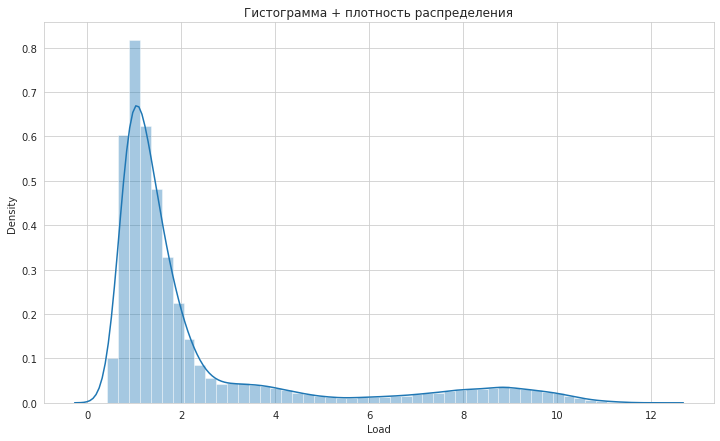

In [173]:
x = data['Load']
with sns.plotting_context(font_scale=1.5), sns.axes_style('whitegrid'):
    plt.figure(figsize=(12, 7))
    plt.title(r"Гистограмма + плотность распределения")
    plt.xlabel('МВт');
    sns.distplot(x);

In [174]:
# Фичи созданные искусственно на этапе формирования датасета:
# Type: Выходной/рабочий
# DoY: День года
# DoW: День недели
# Hour: час
# Hour/2: номер получасовки в сутках
# Day: День в месяце
# DiM: Начало/конец месяца - день месяца, деленный на число дней в месяце

In [175]:
#  Добавим 1-ую фичу
# потребление и план будет как неделю назад. Если типы дней расходятся из-за праздников, то берется ближайший дальше того же типа 
from tqdm import tnrange,tqdm
cal_pred = np.concatenate([data.Load.iloc[:48*7],data.Load.mean()*np.ones(data.shape[0]-48*7)])
cal_plan = np.concatenate([data.plan.iloc[:48*7],data.plan.iloc[:-48*7]])
for i in tnrange(48*7,data.shape[0]):
    if data.Type.iloc[i] == data.Type.iloc[i-48*7]:
        cal_pred[i] = data.Load.iloc[i-48*7]
        cal_plan[i] = data.plan.iloc[i-48*7]
    else:
        try:
            prev_same = max(data.index[(data.Type == data.Type.iloc[i])
                                      &(data.DoW == data.DoW.iloc[i])]&(data.index<i))
            cal_pred[i] = data.Load.iloc[prev_same]
            cal_plan[i] = data.plan.iloc[prev_same]
        except:
            cal_pred[i] = data.Load.iloc[i-48*7]
            cal_plan[i] = data.plan.iloc[i-48*7]


Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`


  0%|          | 0/117153 [00:00<?, ?it/s]

In [176]:
#  Добавим 2-ую фичу
# потребление и план будет завтра как вчера. 
trivial = np.concatenate([data.Load.iloc[:48],data.Load.iloc[:-48]])
triv_plan = np.concatenate([data.plan.iloc[:48],data.plan.iloc[:-48]])

In [177]:
# Добавим эти фичи к общему датасету
data['cal_pred'] = cal_pred
data['cal_plan'] = cal_plan 

data['trivial'] = trivial
data['triv_plan'] = triv_plan

In [178]:
# проверяем
data[-95:-94].Load.values[0]==data[-95+48:-94+48].trivial.values[0]
# data[-95:-94].Temp.values[0]==data[-95+48:-94+48].triv_T.values[0]

True

In [179]:

data.index=pd.to_datetime(data['datehour'])
data  = data.drop(['datehour'], axis=1)
data

,Load,Type,DoY,DoW,Hour,Hour/2,Day,DiM,Temp,H,fi,V,plan,cal_pred,cal_plan,trivial,triv_plan
datehour,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00,1.518,Выходной,1,3,0,1.0,1,0.032258,-5.000000,724.25000,71.000000,3.000000,с,1.518,с,1.518,с
2015-01-01 00:30:00,1.435,Выходной,1,3,0,2.0,1,0.032258,-5.052083,724.15625,71.005208,3.026042,с,1.435,с,1.435,с
2015-01-01 01:00:00,1.362,Выходной,1,3,1,3.0,1,0.032258,-5.104167,724.06250,71.010417,3.052083,с,1.362,с,1.362,с
2015-01-01 01:30:00,1.402,Выходной,1,3,1,4.0,1,0.032258,-5.156250,723.96875,71.015625,3.078125,с,1.402,с,1.402,с
2015-01-01 02:00:00,1.398,Выходной,1,3,2,5.0,1,0.032258,-5.208333,723.87500,71.020833,3.104167,с,1.398,с,1.398,с
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-29 06:00:00,2.353,Выходной,29,5,6,13.0,29,0.935484,-21.947500,777.09375,97.125000,1.526250,к,1.956,с,1.966,с
2022-01-29 06:30:00,2.524,Выходной,29,5,6,14.0,29,0.935484,-21.947500,777.09375,97.125000,1.526250,к,2.040,с,2.013,с
2022-01-29 07:00:00,3.150,Выходной,29,5,7,15.0,29,0.935484,-21.947500,777.09375,97.125000,1.526250,к,1.980,с,2.132,с


In [180]:
# # генерируем фичи
# import tqdm
# import sys

# PERIODS = ["1D","2D", "3D","4D","5D","6D","7D","8D","9D","10D","14D","21D","30D","45D"]
# AGGREGATES = ["mean", "max","min"]

# dfts=pd.DataFrame(data['Load'])
# all_features = []

# for period in tqdm.tqdm_notebook(PERIODS):
#     for agg in AGGREGATES:
#         rolling_features = dfts.rolling(period).aggregate(agg)
#         rolling_features.rename(lambda x: "_".join([x, period, agg]), axis=1, inplace=True)
#         all_features.append(rolling_features)
        
# all_features = pd.concat(all_features, axis=1)

# data=pd.concat([data,
#               all_features], axis=1)
# data.head()

In [181]:
data.columns

Index(['Load', 'Type', 'DoY', 'DoW', 'Hour', 'Hour/2', 'Day', 'DiM', 'Temp',
       'H', 'fi', 'V', 'plan', 'cal_pred', 'cal_plan', 'trivial', 'triv_plan'],
      dtype='object')

In [182]:
#Посмотрим в каких фичах больше всего пропусков
missingValues = data.columns[data.isnull().any()].tolist()
df_na=pd.isnull(data[missingValues]).sum().sort_values(ascending=False)
df_na

Series([], dtype: float64)

In [183]:
# corrmat = data.corr()
# sns.set(font_scale=1.4)
# plt.figure(figsize=(15, 15))
# sns.heatmap(corrmat)

In [184]:
data.head(5)

,Load,Type,DoY,DoW,Hour,Hour/2,Day,DiM,Temp,H,fi,V,plan,cal_pred,cal_plan,trivial,triv_plan
datehour,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00,1.518,Выходной,1,3,0,1.0,1,0.032258,-5.000000,724.25000,71.000000,3.000000,с,1.518,с,1.518,с
2015-01-01 00:30:00,1.435,Выходной,1,3,0,2.0,1,0.032258,-5.052083,724.15625,71.005208,3.026042,с,1.435,с,1.435,с
2015-01-01 01:00:00,1.362,Выходной,1,3,1,3.0,1,0.032258,-5.104167,724.06250,71.010417,3.052083,с,1.362,с,1.362,с
2015-01-01 01:30:00,1.402,Выходной,1,3,1,4.0,1,0.032258,-5.156250,723.96875,71.015625,3.078125,с,1.402,с,1.402,с
2015-01-01 02:00:00,1.398,Выходной,1,3,2,5.0,1,0.032258,-5.208333,723.87500,71.020833,3.104167,с,1.398,с,1.398,с


In [185]:
# удалим фичу DiM из-за большой корреляции
# data.drop(['DiM','Hour/2'],axis=1,inplace=True)

In [186]:
data.head(5)

,Load,Type,DoY,DoW,Hour,Hour/2,Day,DiM,Temp,H,fi,V,plan,cal_pred,cal_plan,trivial,triv_plan
datehour,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00,1.518,Выходной,1,3,0,1.0,1,0.032258,-5.000000,724.25000,71.000000,3.000000,с,1.518,с,1.518,с
2015-01-01 00:30:00,1.435,Выходной,1,3,0,2.0,1,0.032258,-5.052083,724.15625,71.005208,3.026042,с,1.435,с,1.435,с
2015-01-01 01:00:00,1.362,Выходной,1,3,1,3.0,1,0.032258,-5.104167,724.06250,71.010417,3.052083,с,1.362,с,1.362,с
2015-01-01 01:30:00,1.402,Выходной,1,3,1,4.0,1,0.032258,-5.156250,723.96875,71.015625,3.078125,с,1.402,с,1.402,с
2015-01-01 02:00:00,1.398,Выходной,1,3,2,5.0,1,0.032258,-5.208333,723.87500,71.020833,3.104167,с,1.398,с,1.398,с


In [188]:
X  = data.drop(['Load'], axis=1)
y = data.Load

In [189]:

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    train_size=0.8, 
                                                    random_state=42)
categorical_features=['Type','plan','cal_plan','triv_plan']

In [190]:
# #выбираем фичи на BorutaPy

# from boruta import BorutaPy 
# from catboost import CatBoostRegressor
# from typing import List, Optional
# import scipy.stats

# class LGBMFeatureEstimator():
#     def __init__(self, params, n_estimators: int=50):
#         self.params = params
#         self.n_estimators = n_estimators

#     def get_params(self):
#         return self.params

#     def set_params(self, n_estimators:Optional[int]=None, random_state:Optional[int]=None):
#         if n_estimators is not None:
#             self.n_estimators = n_estimators

#     def fit(self, X: pd.DataFrame, y: pd.Series):
#         CatB=CatBoostRegressor(iterations=self.n_estimators,depth=6,border_count=255)        
#         model = CatB.fit(X, y,verbose=False,plot=False)
#         self.feature_importances_ = model.feature_importances_
        
# # подбор фич при помощи BorutaPy
# feat_estimator = LGBMFeatureEstimator({"seed": 42}, 100)

# feat_selector = BorutaPy(feat_estimator, n_estimators=300, verbose=2, random_state=1)
# feat_selector.fit(X_train.drop(categorical_features, axis=1).values,
#         y_train.values)

# X_train=X_train[categorical_features+list(X_train.drop(categorical_features, axis=1).columns[feat_selector.support_])].copy()

In [191]:
# X_test=X_test[categorical_features+list(X_test.drop(categorical_features, axis=1).columns[feat_selector.support_])].copy()

In [192]:
data.head()

,Load,Type,DoY,DoW,Hour,Hour/2,Day,DiM,Temp,H,fi,V,plan,cal_pred,cal_plan,trivial,triv_plan
datehour,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00,1.518,Выходной,1,3,0,1.0,1,0.032258,-5.000000,724.25000,71.000000,3.000000,с,1.518,с,1.518,с
2015-01-01 00:30:00,1.435,Выходной,1,3,0,2.0,1,0.032258,-5.052083,724.15625,71.005208,3.026042,с,1.435,с,1.435,с
2015-01-01 01:00:00,1.362,Выходной,1,3,1,3.0,1,0.032258,-5.104167,724.06250,71.010417,3.052083,с,1.362,с,1.362,с
2015-01-01 01:30:00,1.402,Выходной,1,3,1,4.0,1,0.032258,-5.156250,723.96875,71.015625,3.078125,с,1.402,с,1.402,с
2015-01-01 02:00:00,1.398,Выходной,1,3,2,5.0,1,0.032258,-5.208333,723.87500,71.020833,3.104167,с,1.398,с,1.398,с


In [200]:
model = CatBoostRegressor(iterations=10000, depth=9, learning_rate=0.03,
                          # rsm=0.3,
                          loss_function='MAE',
                            eval_metric='MAPE',
                          od_wait= 500, od_type= 'Iter',
                          use_best_model=True, random_seed=42)


In [201]:
len(X_train.columns)==len(X_test.columns)

True

In [202]:

# model.fit(X_train[['Type', 'plan', 'cal_plan', 'triv_plan', 'DoY', 'DoW', 'Hour',
#        'Day', 'Temp', 'H', 'fi', 'V', 'cal_pred', 'trivial']],y_train,
#         cat_features=categorical_features,
#         eval_set=(X_test[['Type', 'plan', 'cal_plan', 'triv_plan', 'DoY', 'DoW', 'Hour',
#        'Day', 'Temp', 'H', 'fi', 'V', 'cal_pred', 'trivial']], y_test),
#           plot=True,  verbose=False,use_best_model=True)
# print(model.get_best_iteration())

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

9999


In [196]:

model.fit(X_train,y_train,
        cat_features=categorical_features,
        eval_set=(X_test, y_test),
          plot=True,  verbose=False,use_best_model=True)
print(model.get_best_iteration())

In [203]:
model.save_model('/home/playground/Potreb/Models/'+GTP+'_new.c5')

In [198]:
pd.DataFrame({'Feature':model.feature_names_,'Importance':model.feature_importances_}).sort_values("Importance",ascending=False).head(40)

In [199]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)